## Load lib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyramses

## Load Models

In [2]:
from agc_models import end_simulation
from agc_models import move_file
from agc_models import sfc
from agc_models import Gens
from agc_models import sortGens
from agc_models import multipleIncreaseDelay

from agc_models import chop_curve
from agc_models import rate_of_change
from agc_models import settling_time
from agc_models import curve_of_rate_of_change

## Load a simulator instance

In [3]:
ram = pyramses.sim()

## Load saved test-case & Add more observation(s)

In [4]:
case = pyramses.cfg('cmd.txt')
case.addRunObs('MS CCGTG2.01')  # Monitor, will write real-time (voltage-time or) frequency-time data of bus G2 (GBdynHVDC.dat)
monitor = ['CCGTG2.01']

## Universe Parameters. Start: 300sec, Settling before: 1200sec (+900sec = +15min), End: 1500sec; Time step: 1sec.

In [5]:
prepared_folder_address = 'cur'
nominal_frequency = 1.0
start_time = 150.0
settling_end_time = 800.0
end_time = 800.0  # (dst file)
agcTimeStep = 1.0

## Breaker (one of distrubances) & Selected generators (to help fix errors)

In [6]:
breaker = '8-10a_8-10b' # (dst file)

# gen's code     name       weight  mini delay              
gen4_2 = Gens('COALG4.02', 0.200, 0.1220)    # 2386.699/17489.086 = 0.136468
gen11_2 = Gens('COALG11.02', 0.200, 0.1220)  # 1559.337/17489.086 = 0.089161
gen15_2 = Gens('COALG15.02', 0.200, 0.0620)  # 8027.401/17489.086 = 0.458995
gen16_2 = Gens('COALG16.02', 0.200, 0.1220)  # 3911.223/17489.086 = 0.223638
gen23_2 = Gens('COALG23.02', 0.200, 0.0620)  # 1604.416/17489.086 = 0.091738

liST = []
liST.append(gen4_2)
liST.append(gen11_2)
liST.append(gen15_2)
liST.append(gen16_2)
liST.append(gen23_2)
list_of_gens, weight_of_gens,  mini_list_of_td = sortGens(liST)

print(list_of_gens)
print(weight_of_gens)
print(mini_list_of_td)

['COALG15.02', 'COALG23.02', 'COALG4.02', 'COALG11.02', 'COALG16.02']
[0.2, 0.2, 0.2, 0.2, 0.2]
[0.062, 0.062, 0.122, 0.122, 0.122]


## Test with fixed kp and ki

In [7]:
if __name__ == '__main__':
    kp = 0.31
    ki = 0.01
    list_of_td = multipleIncreaseDelay(100, mini_list_of_td)  # 100%
    
    kp = "{0:.4f}".format(round(float(kp),4))
    ki = "{0:.4f}".format(round(float(ki),4))
    print("kp = " + str(kp))
    print("ki = " + str(ki))
    print(list_of_td)

    sfc(ram, case, monitor, list_of_gens, weight_of_gens, list_of_td, prepared_folder_address, start_time, end_time, agcTimeStep, breaker, nominal_frequency, kp, ki)

kp = 0.3100
ki = 0.0100
[0.062, 0.062, 0.122, 0.122, 0.122]
kill gnuplot successfully
endSim() successfully
delete ram & case successfully
re-write cur successfully
copy cur successfully
delete temp_display(_).cur successfully
delete some trace files successfully


## Embed the frequency/voltage response in the output
**https://pyramses.paristidou.info/_modules/pyramses/extractor.html#extractor.getSync**

In [8]:
ext = pyramses.extractor(case.getTrj())

## A. Check frequency in the grid via monitor

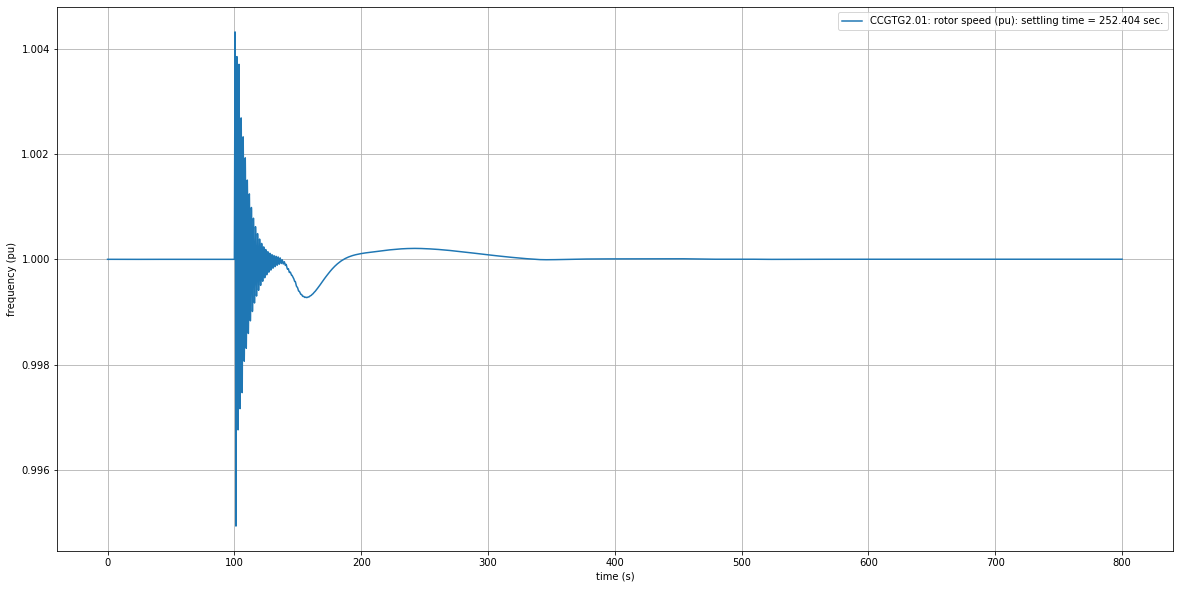

In [9]:
# t_ori, f_ori, t, f = chop_curve(ext.getSync('CCGTG2.01').S.time, ext.getSync('CCGTG2.01').S.value, chop_value=start_time)
t = ext.getSync('CCGTG2.01').S.time
f = ext.getSync('CCGTG2.01').S.value
realSettlingTime = settling_time(t, f, 1/5000, nominal_frequency)
# ext.getSync('CCGTG2.01').S.plot()
fig = plt.figure(figsize=(20,10))
plt.plot(t, f, label = ext.getSync('CCGTG2.01').S.msg + ": settling time = " + str(realSettlingTime) + " sec.")
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('frequency (pu)')
plt.grid(True)

## B. Check power & power rate of the five generators (power rate = delta power / delta time, should be around 10% (CCGT) or 5% (COAL) of power capacity per min)

### 1. Pnom(G4.02) = 2028.694 MW

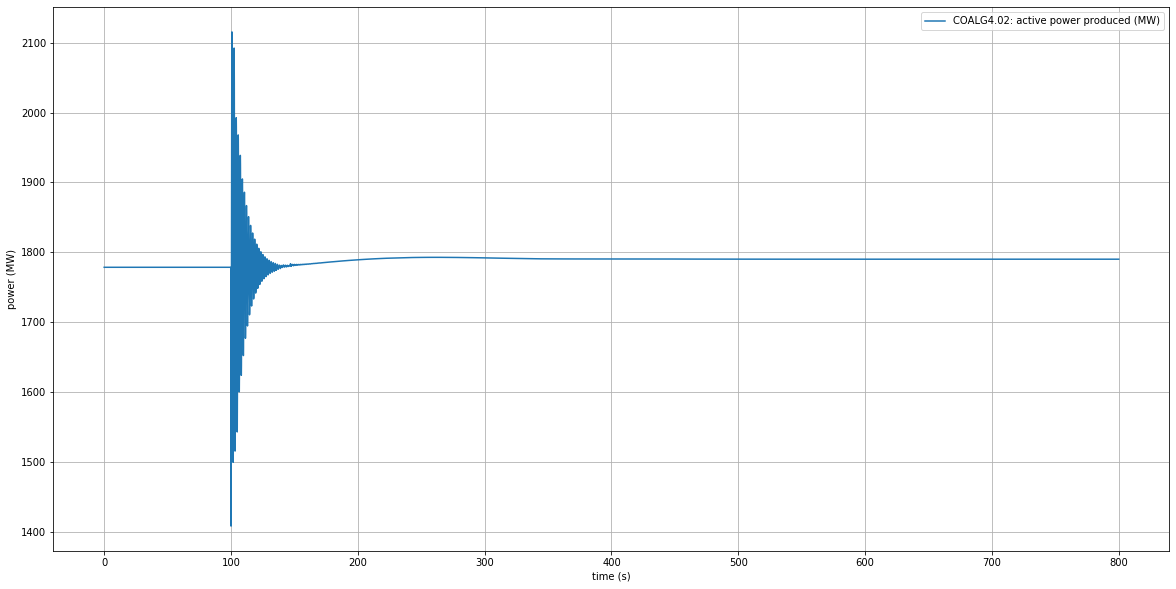

In [10]:
# ext.getSync('COALG4.02').P.plot()
fig = plt.figure(figsize=(20,10))
plt.plot(ext.getSync('COALG4.02').P.time, ext.getSync('COALG4.02').P.value, label = ext.getSync('COALG4.02').P.msg)
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('power (MW)')
plt.grid(True)

##### COALG4.02: 5% capacity/min = 101.435 MW/min:

ValueError: x and y must have same first dimension, but have shapes (651,) and (650,)

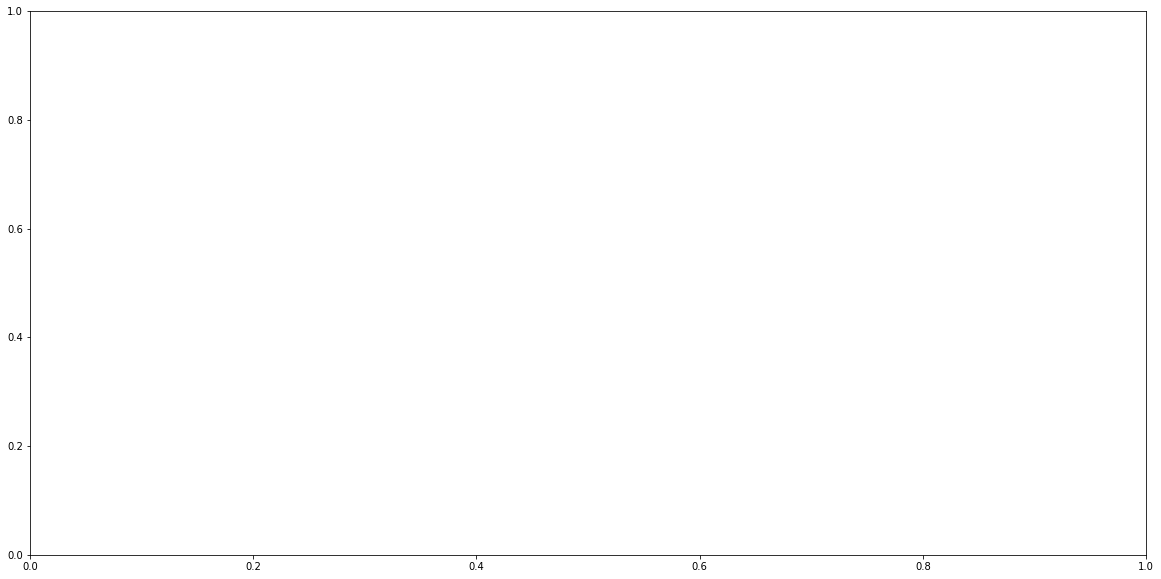

In [11]:
curve_of_rate_of_change('COALG4.02', ext.getSync('COALG4.02').P.time, ext.getSync('COALG4.02').P.value, start_time, settling_end_time, agcTimeStep, unit_converter=60)

### 2. Pnom(G11.02) = 1403.403 MW

In [ ]:
# ext.getSync('COALG11.02').P.plot()
fig = plt.figure(figsize=(20,10))
plt.plot(ext.getSync('COALG11.02').P.time, ext.getSync('COALG11.02').P.value, label = ext.getSync('COALG11.02').P.msg)
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('power (MW)')
plt.grid(True)

##### COALG11.02: 5% capacity/min = 70.170 MW/min

In [ ]:
curve_of_rate_of_change('COALG11.02', ext.getSync('COALG11.02').P.time, ext.getSync('COALG11.02').P.value, start_time, settling_end_time, agcTimeStep, unit_converter=60)

### 3. Pnom(G15.02) = 6823.291 MW

In [ ]:
# ext.getSync('COALG15.02').P.plot()
fig = plt.figure(figsize=(20,10))
plt.plot(ext.getSync('COALG15.02').P.time, ext.getSync('COALG15.02').P.value, label = ext.getSync('COALG15.02').P.msg)
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('power (MW)')
plt.grid(True)

##### COALG15.02: 5% capacity/min = 341.165 MW/min

In [ ]:
curve_of_rate_of_change('COALG15.02', ext.getSync('COALG15.02').P.time, ext.getSync('COALG15.02').P.value, start_time, settling_end_time, agcTimeStep, unit_converter=60)

### 4. Pnom(G16.02) = 3520.101 MW

In [ ]:
# ext.getSync('COALG16.02').P.plot()
fig = plt.figure(figsize=(20,10))
plt.plot(ext.getSync('COALG16.02').P.time, ext.getSync('COALG16.02').P.value, label = ext.getSync('COALG16.02').P.msg)
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('power (MW)')
plt.grid(True)

##### COALG16.02: 5% capacity/min = 176.005 MW/min

In [ ]:
curve_of_rate_of_change('COALG16.02', ext.getSync('COALG16.02').P.time, ext.getSync('COALG16.02').P.value, start_time, settling_end_time, agcTimeStep, unit_converter=60)

### 5. Pnom(G23.02) = 1363.753 MW

In [ ]:
# ext.getSync('COALG23.02').P.plot()
fig = plt.figure(figsize=(20,10))
plt.plot(ext.getSync('COALG23.02').P.time, ext.getSync('COALG23.02').P.value, label = ext.getSync('COALG23.02').P.msg)
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('power (MW)')
plt.grid(True)

##### COALG23.02: 5% capacity/min = 68.188 MW/min

In [ ]:
curve_of_rate_of_change('COALG23.02', ext.getSync('COALG23.02').P.time, ext.getSync('COALG23.02').P.value, start_time, settling_end_time, agcTimeStep, unit_converter=60)